In [1]:
from update_utilities import update_utilities_class
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# discriminator

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.2)
        torch.nn.init.constant_(m.bias.data,0)

In [3]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(3,64,kernel_size=3,stride=2,padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            torch.nn.Dropout2d(0.2),
            torch.nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.2),
            torch.nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(8192,512),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512,1)
        )
        self.apply(weights_init)
    def forward(self,x):
        return self.model(x)

In [4]:
discriminator = Discriminator()


In [5]:
summary(discriminator,torch.zeros(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 32, 32]         --
|    └─MaxPool2d: 2-7                    [-1, 128, 16, 16]         --
|    └─Dropout2d: 2-8                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-9                       [-1, 256, 8, 8]           295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-11                   [-1, 256, 8, 8]           --
|    └─Dropout2d: 2-12                   [-1, 256, 8, 8]           --


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 64, 64]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 64, 64]          128
|    └─LeakyReLU: 2-3                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-4                       [-1, 128, 32, 32]         73,856
|    └─BatchNorm2d: 2-5                  [-1, 128, 32, 32]         256
|    └─LeakyReLU: 2-6                    [-1, 128, 32, 32]         --
|    └─MaxPool2d: 2-7                    [-1, 128, 16, 16]         --
|    └─Dropout2d: 2-8                    [-1, 128, 16, 16]         --
|    └─Conv2d: 2-9                       [-1, 256, 8, 8]           295,168
|    └─BatchNorm2d: 2-10                 [-1, 256, 8, 8]           512
|    └─LeakyReLU: 2-11                   [-1, 256, 8, 8]           --
|    └─Dropout2d: 2-12                   [-1, 256, 8, 8]           --


# generator

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(noise_dim,256*4, kernel_size=10,padding=1),
            torch.nn.BatchNorm2d(256*4),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*4,256*4,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(256*4),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*4,256*2,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(256*2),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256*2,256,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(128,64,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(64,64,kernel_size=3,padding=1,stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(64,32,kernel_size=4,padding=1,stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout2d(0.1),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1, stride=1),
            torch.nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator(noise_dim=2048)

In [8]:
summary(generator,torch.zeros(1,2048,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 128, 128]         --
|    └─ConvTranspose2d: 2-1              [-1, 1024, 8, 8]          209,716,224
|    └─BatchNorm2d: 2-2                  [-1, 1024, 8, 8]          2,048
|    └─LeakyReLU: 2-3                    [-1, 1024, 8, 8]          --
|    └─Dropout2d: 2-4                    [-1, 1024, 8, 8]          --
|    └─ConvTranspose2d: 2-5              [-1, 1024, 16, 16]        16,778,240
|    └─BatchNorm2d: 2-6                  [-1, 1024, 16, 16]        2,048
|    └─LeakyReLU: 2-7                    [-1, 1024, 16, 16]        --
|    └─Dropout2d: 2-8                    [-1, 1024, 16, 16]        --
|    └─ConvTranspose2d: 2-9              [-1, 512, 32, 32]         8,389,120
|    └─BatchNorm2d: 2-10                 [-1, 512, 32, 32]         1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 32, 32]         --
|    └─Dropout2d: 2-12                   [-1, 512, 3

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3, 128, 128]         --
|    └─ConvTranspose2d: 2-1              [-1, 1024, 8, 8]          209,716,224
|    └─BatchNorm2d: 2-2                  [-1, 1024, 8, 8]          2,048
|    └─LeakyReLU: 2-3                    [-1, 1024, 8, 8]          --
|    └─Dropout2d: 2-4                    [-1, 1024, 8, 8]          --
|    └─ConvTranspose2d: 2-5              [-1, 1024, 16, 16]        16,778,240
|    └─BatchNorm2d: 2-6                  [-1, 1024, 16, 16]        2,048
|    └─LeakyReLU: 2-7                    [-1, 1024, 16, 16]        --
|    └─Dropout2d: 2-8                    [-1, 1024, 16, 16]        --
|    └─ConvTranspose2d: 2-9              [-1, 512, 32, 32]         8,389,120
|    └─BatchNorm2d: 2-10                 [-1, 512, 32, 32]         1,024
|    └─LeakyReLU: 2-11                   [-1, 512, 32, 32]         --
|    └─Dropout2d: 2-12                   [-1, 512, 3

# other utilities

In [9]:
loss_fn = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=2e-4)

In [10]:
def noise_generator(device,batch_size=16, dimension=512):
    return torch.randn((batch_size, dimension)).to(device)

# data pipeline

In [11]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [12]:
folder = "../../Datasets/annotated_img/images/train2017"

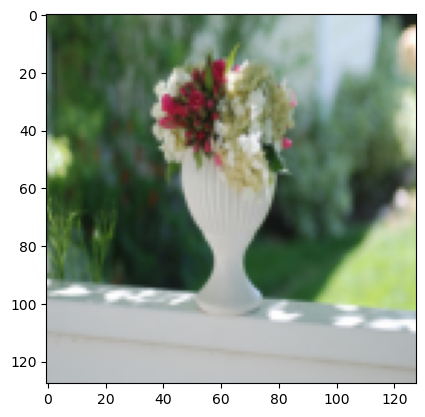

In [13]:
image = folder + "/000000000030.jpg"
image = Image.open(image).convert("RGB")
image_transformed = img_transforms(image)
plt.imshow(np.array(image_transformed).transpose(1,2,0))

In [14]:
import os
from PIL import Image
class image_dataset(Dataset):
    def __init__(self, image_path, transform):
        super().__init__()
        self.image_path = image_path
        self.images = list(os.listdir(image_path))
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path,self.images[idx])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        return image

In [15]:
train_dataset = image_dataset(folder,img_transforms)

In [16]:
len(train_dataset)

118287

In [17]:
from torch.utils.data import RandomSampler
batch_size = 128
num_samples = 19200
train_sampler = RandomSampler(train_dataset,replacement=False,num_samples=num_samples)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)

# training routine

In [18]:
from torch_snippets import *

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = "deep_200M"
if not os.path.exists(model_name):
    os.makedirs(model_name)


In [20]:
def train_discriminator(discriminator, real_data, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones((len(real_data),1)).to(device))
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros((len(fake_data),1)).to(device))
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [21]:
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.ones((len(fake_data),1)).to(device))
    loss_fake.backward()
    optimizer.step()
    return loss_fake

EPOCH: 3.000  d_loss: 0.063  g_loss: 5.836  (409.33s - 1637.31s remaining)
EPOCH: 6.000  d_loss: 0.283  g_loss: 4.762  (809.08s - 1213.62s remaining))
EPOCH: 9.000  d_loss: 0.307  g_loss: 4.059  (1201.83s - 801.22s remaining))
EPOCH: 12.000  d_loss: 0.418  g_loss: 3.428  (1591.66s - 397.91s remaining)
EPOCH: 15.000  d_loss: 0.488  g_loss: 3.327  (1983.10s - 0.00s remaining)))


100%|██████████| 116/116 [00:00<00:00, 2242.73it/s]


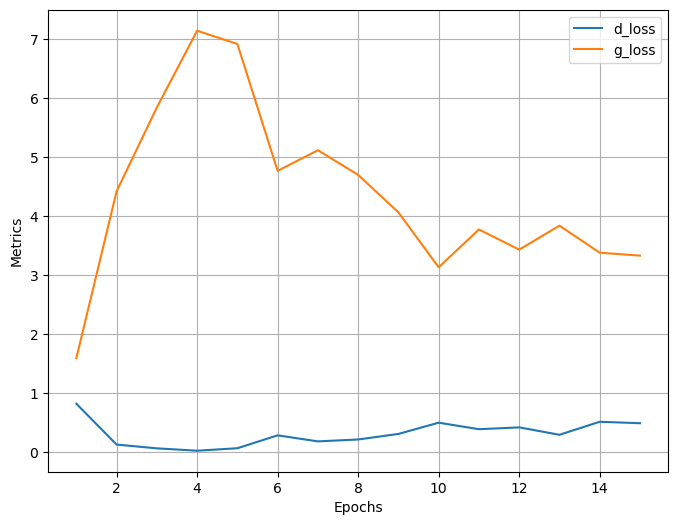

In [22]:
N = len(train_dataloader)
noise_dim = 2048
best_g_loss = 2
num_epochs = 15
record = False
count = 0
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(),
                   end = '\r')
        count += 1
        if count >= 50:
            record = True
        if record == True and g_loss <= best_g_loss:
            torch.save(generator.state_dict(),model_name+"/generator_best_"+str(round(g_loss.item(),2))+".pth")
            best_g_loss = g_loss
    if (epoch + 1) % 3 == 0:
        torch.save(generator.state_dict(),model_name+"/generator_epoch"+str(epoch+1)+".pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator_epoch"+str(epoch+1)+".pth")
        log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

EPOCH: 6.000  d_loss: 0.543  g_loss: 2.913  (796.66s - 3186.65s remaining)
EPOCH: 12.000  d_loss: 0.819  g_loss: 1.940  (1580.19s - 2370.29s remaining)
EPOCH: 18.000  d_loss: 0.717  g_loss: 2.412  (2358.78s - 1572.52s remaining)
EPOCH: 24.000  d_loss: 0.886  g_loss: 1.905  (3140.62s - 785.16s remaining))
EPOCH: 30.000  d_loss: 0.804  g_loss: 2.135  (3918.13s - 0.00s remaining)))


100%|██████████| 131/131 [00:00<00:00, 1114.77it/s]


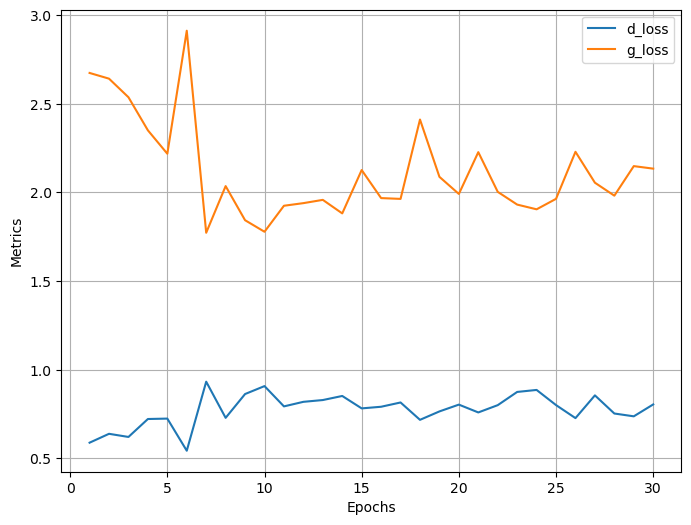

In [30]:
N = len(train_dataloader)
noise_dim = 2048
best_g_loss = 1.5
num_epochs = 30
record = False
count = 0
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(),
                   end = '\r')
        count += 1
        if count >= 100:
            record = True
        if record == True and g_loss <= best_g_loss:
            torch.save(generator.state_dict(),model_name+"/generator_best_"+str(round(g_loss.item(),2))+".pth")
            best_g_loss = g_loss
    if (epoch + 1) % 6 == 0:
        torch.save(generator.state_dict(),model_name+"/generator_epoch"+str(epoch+1)+".pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator_epoch"+str(epoch+1)+".pth")
        log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

In [70]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=5e-5)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=1e-4)

EPOCH: 6.000  d_loss: 0.828  g_loss: 1.876  (788.20s - 7093.81s remaining)
EPOCH: 12.000  d_loss: 0.981  g_loss: 1.548  (1567.65s - 6270.61s remaining)
EPOCH: 18.000  d_loss: 1.034  g_loss: 1.375  (2346.55s - 5475.29s remaining)
EPOCH: 24.000  d_loss: 1.016  g_loss: 1.423  (3124.88s - 4687.32s remaining)
EPOCH: 30.000  d_loss: 0.981  g_loss: 1.467  (3904.41s - 3904.41s remaining)
EPOCH: 36.000  d_loss: 0.971  g_loss: 1.516  (4680.92s - 3120.61s remaining)
EPOCH: 42.000  d_loss: 0.996  g_loss: 1.498  (5460.64s - 2340.27s remaining)
EPOCH: 48.000  d_loss: 0.967  g_loss: 1.474  (6239.94s - 1559.99s remaining)
EPOCH: 54.000  d_loss: 0.953  g_loss: 1.483  (7083.51s - 787.06s remaining))
EPOCH: 60.000  d_loss: 0.968  g_loss: 1.568  (7927.68s - 0.00s remaining)))


100%|██████████| 161/161 [00:00<00:00, 654.74it/s]


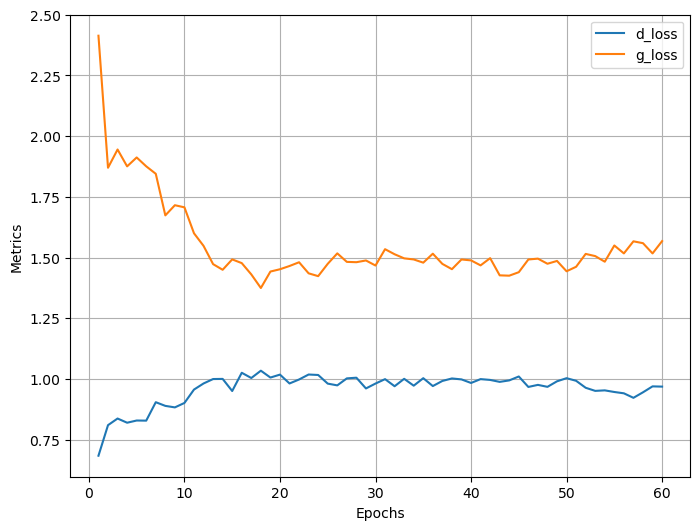

In [71]:
N = len(train_dataloader)
noise_dim = 2048
best_g_loss = 1.5
num_epochs = 60
record = False
count = 0
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(),
                   end = '\r')
        count += 1
        if count >= 100:
            record = True
        if record == True and g_loss <= best_g_loss:
            torch.save(generator.state_dict(),model_name+"/generator_best_"+str(round(g_loss.item(),2))+".pth")
            best_g_loss = g_loss
    if (epoch + 1) % 6 == 0:
        torch.save(generator.state_dict(),model_name+"/generator_epoch"+str(epoch+1)+".pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator_epoch"+str(epoch+1)+".pth")
        log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

In [159]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=2e-5)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=5e-5)

EPOCH: 6.000  d_loss: 0.970  g_loss: 1.513  (779.01s - 7011.09s remaining)
EPOCH: 12.000  d_loss: 0.958  g_loss: 1.454  (1555.60s - 6222.40s remaining)
EPOCH: 18.000  d_loss: 0.966  g_loss: 1.465  (2335.94s - 5450.54s remaining)
EPOCH: 24.000  d_loss: 0.961  g_loss: 1.514  (3115.71s - 4673.56s remaining)
EPOCH: 30.000  d_loss: 0.950  g_loss: 1.517  (3894.93s - 3894.93s remaining)
EPOCH: 36.000  d_loss: 0.927  g_loss: 1.521  (4670.59s - 3113.73s remaining)
EPOCH: 42.000  d_loss: 0.934  g_loss: 1.526  (5448.55s - 2335.09s remaining)
EPOCH: 48.000  d_loss: 0.942  g_loss: 1.526  (6229.94s - 1557.49s remaining)
EPOCH: 54.000  d_loss: 0.942  g_loss: 1.540  (7008.34s - 778.70s remaining))
EPOCH: 60.000  d_loss: 0.918  g_loss: 1.537  (7883.19s - 0.00s remaining)))


100%|██████████| 161/161 [00:00<00:00, 299.22it/s]


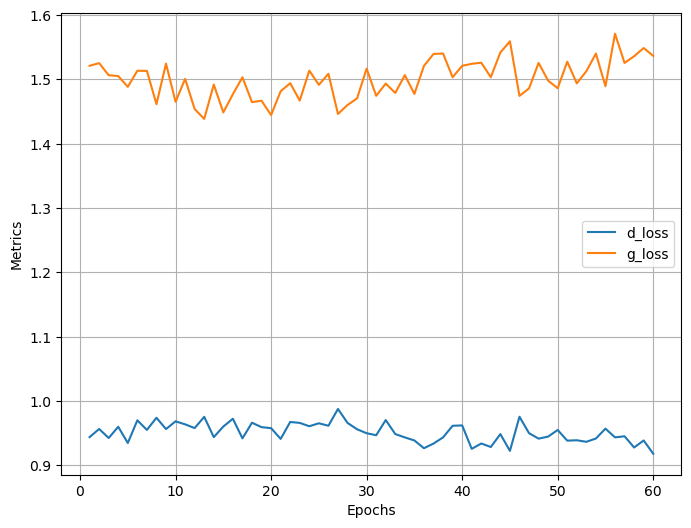

In [160]:
N = len(train_dataloader)
noise_dim = 2048
best_g_loss = 0.8
num_epochs = 60
record = False
count = 0
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        fake_data = fake_data.detach()
        d_loss = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim).view(batch_size,noise_dim,1,1)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(),
                   end = '\r')
        count += 1
        if count >= 100:
            record = True
        if record == True and g_loss <= best_g_loss:
            torch.save(generator.state_dict(),model_name+"/generator_best_"+str(round(g_loss.item(),2))+".pth")
            best_g_loss = g_loss
    if (epoch + 1) % 6 == 0:
        torch.save(generator.state_dict(),model_name+"/generator_epoch"+str(epoch+1)+".pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator_epoch"+str(epoch+1)+".pth")
        log.report_avgs(epoch+1)
log.plot_epochs(['d_loss','g_loss'])

In [243]:
generator.load_state_dict(torch.load("deep_200M/generator_best_0.56.pth"))

<All keys matched successfully>

tensor([[0.4192]], device='cuda:0', grad_fn=<SigmoidBackward0>)

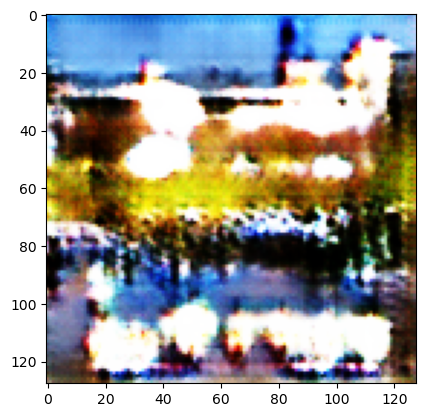

In [199]:
img = generator(noise_generator(device,1,2048).view(1,2048,1,1)).to(device)
print(torch.nn.Sigmoid()(discriminator(img)))
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

0.7246077656745911

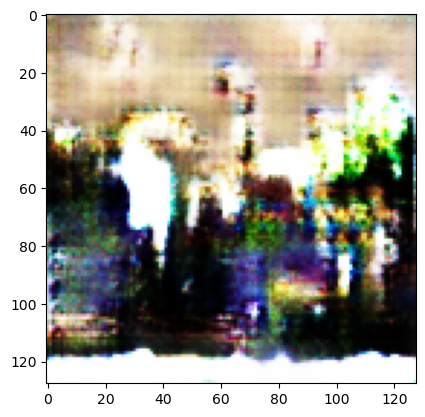

In [247]:
p = 0
while p < 0.7:
    img = generator(noise_generator(device,1,2048).view(1,2048,1,1)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

0.9233351349830627

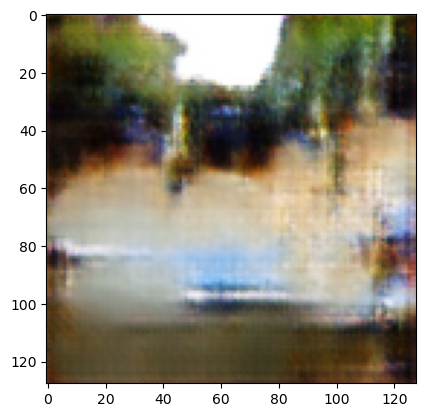

In [242]:
p = 0
while p < 0.7:
    img = generator(noise_generator(device,1,2048).view(1,2048,1,1)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)